In [1]:
#%pip install xgboost
#%pip install tabulate
# Importing  libraries
import xgboost as xgb
import numpy as np 
import pandas as pd
import seaborn as sns
import json
#Plotting
import matplotlib.pyplot as plt
#Statistical fitting of models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import time
# Importing the libraries required for logistic regression , random forests  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, brier_score_loss
# Loading required libraries for cross validation 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score


from tabulate import tabulate
from scipy.stats import norm

In [2]:
with open('shots_model_0.json') as f:
    shots_model= json.load(f)

# Converting the laoded into datframe
shots_model = pd.DataFrame(shots_model)

shots_model

,Goal,X,Y,Left_Foot,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,C,Distance,Angle,1H,2H
0,1,12.0,41.0,0,1,0,0,1,0,0,0,0,0,0,9.0,13.891814,27.184065,1,0
1,0,15.0,52.0,1,0,0,0,0,0,0,0,0,0,0,2.0,15.803560,26.002161,1,0
2,0,19.0,33.0,1,0,0,0,0,0,0,0,0,0,0,17.0,22.805811,16.077018,1,0
3,0,25.0,30.0,0,1,0,0,1,0,0,0,0,0,0,20.0,29.292704,12.815892,1,0
4,0,10.0,39.0,1,0,0,0,0,0,0,0,0,0,0,11.0,12.703248,27.447608,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,0,7.0,66.0,0,1,0,0,0,0,0,0,0,0,0,16.0,12.735089,19.880214,0,1
33938,0,10.0,32.0,0,1,0,0,0,0,0,0,0,0,0,18.0,15.720687,18.201936,0,1
33939,1,8.0,25.0,1,0,0,0,1,0,0,0,0,0,0,25.0,18.292690,10.836256,0,1
33940,0,18.0,30.0,0,1,0,0,0,0,1,0,0,0,0,20.0,22.939268,15.097923,0,1


In [3]:
# Creating a dataframe containing all the features
X = shots_model[['C','Right_Foot','GLC', 'GLR', 'GLL', 'GC', 'GCR', 'GCL', 'GHC', 'GHR','GHL', '2H' ,'Distance','Angle']]
# Feature data set
X

,C,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,2H,Distance,Angle
0,9.0,1,0,0,1,0,0,0,0,0,0,0,13.891814,27.184065
1,2.0,0,0,0,0,0,0,0,0,0,0,0,15.803560,26.002161
2,17.0,0,0,0,0,0,0,0,0,0,0,0,22.805811,16.077018
3,20.0,1,0,0,1,0,0,0,0,0,0,0,29.292704,12.815892
4,11.0,0,0,0,0,0,0,0,0,0,0,0,12.703248,27.447608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,16.0,1,0,0,0,0,0,0,0,0,0,1,12.735089,19.880214
33938,18.0,1,0,0,0,0,0,0,0,0,0,1,15.720687,18.201936
33939,25.0,0,0,0,1,0,0,0,0,0,0,1,18.292690,10.836256
33940,20.0,1,0,0,0,0,1,0,0,0,0,1,22.939268,15.097923


In [4]:
# Scaling the numeric continous features in our data set
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_continuous = X[['C', 'Distance', 'Angle']] # select only continuous columns
X_scaled = scaler.fit_transform(X_continuous)

X_scaled

array([[-0.43355223, -0.73871869,  0.44413802],
       [-1.33526891, -0.50239097,  0.35154924],
       [ 0.59698112,  0.363219  , -0.42597354],
       ...,
       [ 1.62751447, -0.19468766, -0.83652799],
       [ 0.98343113,  0.37971679, -0.50267458],
       [-0.69118557, -0.79996597,  0.59010791]])

In [5]:
# Dropping the original continuous columns in the dataframe
X = X.drop(['C','Angle','Distance'], axis=1)

# Adding scaled columns to our dataset
X['C'] = X_scaled[:,0]
X['Distance'] = X_scaled[:,1]
X['Angle'] = X_scaled[:,2]

# Finalized Feature Dataset
X

,Right_Foot,GLC,GLR,GLL,GC,GCR,GCL,GHC,GHR,GHL,2H,C,Distance,Angle
0,1,0,0,1,0,0,0,0,0,0,0,-0.433552,-0.738719,0.444138
1,0,0,0,0,0,0,0,0,0,0,0,-1.335269,-0.502391,0.351549
2,0,0,0,0,0,0,0,0,0,0,0,0.596981,0.363219,-0.425974
3,1,0,0,1,0,0,0,0,0,0,0,0.983431,1.165121,-0.681446
4,0,0,0,0,0,0,0,0,0,0,0,-0.175919,-0.885648,0.464784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33937,1,0,0,0,0,0,0,0,0,0,1,0.468164,-0.881712,-0.128036
33938,1,0,0,0,0,0,0,0,0,0,1,0.725798,-0.512636,-0.259510
33939,0,0,0,1,0,0,0,0,0,0,1,1.627514,-0.194688,-0.836528
33940,1,0,0,0,0,1,0,0,0,0,1,0.983431,0.379717,-0.502675


In [6]:
# Creating a data set containing dependent variable 'Goal'
y = shots_model['Goal']

y

0        1
1        0
2        0
3        0
4        0
        ..
33937    0
33938    0
33939    1
33940    0
33941    0
Name: Goal, Length: 33942, dtype: int64

Pour les données de classe déséquilibrées, il est généralement recommandé d'utiliser une validation croisée stratifiée, qui garantit que chaque pli a la même proportion d'échantillons de chaque classe que l'ensemble de données. Cela peut contribuer à garantir que le modèle est capable d'apprendre des exemples de la classe minoritaire et d'améliorer ses performances en matière de prédiction de la classe minoritaire. La validation croisée stratifiée k fois est une méthode courante pour cela, où les données sont divisées en k plis et chaque pli contient à peu près la même proportion d'échantillons de chaque classe.

### First model: Logistic Regression

In [7]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [8]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [9]:
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


In [10]:
# Defining the hyperparameters to tune
# dictionary param_grid specifies the hyperparameters to tune for the logistic regression model. 
# The C parameter is the inverse of the regularization strength, penalty specifies the type of regularization to apply, and class_weight specifies
# how to handle class imbalance.
param_grid_lr = {'C': [0.1, 1, 10, 100],
              'penalty': ['l1', 'l2'],
              'class_weight': ['balanced', {0:weight_0, 1:weight_1}]}

In [11]:
# Defining the outer loop for train-test split
# This code defines the outer loop for cross-validation using StratifiedKFold(). 
# n_splits is the number of folds to use, and shuffle is whether or not to shuffle the data before splitting

cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Defining the inner loop for cross-validation on the training set
# This loop will be used to perform cross-validation on the training set for each combination of hyperparameters.
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [13]:
# Defining the logistic regression model
LR_model = LogisticRegression()


### on  training phase

In [14]:
# Starting the tiemr
start_time = time.time()

# Perform nested cross-validation with grid search

grid = GridSearchCV(LR_model, param_grid=param_grid_lr, cv=cv_inner, scoring='f1', n_jobs=-1)
scores = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

# the array of F1-scores obtained by performing cross-validation on the training set using the GridSearchCV object
scores

array([0.52383447, 0.53080569, 0.53146853, 0.54350161, 0.53772582])

In [15]:
grid.fit(X_train, y_train)
best_lr_model = grid.best_estimator_

# Stopping the timer
end_time = time.time()

lr_training_time = end_time - start_time

c:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\DELL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueErro

In [16]:
# Print the best parameters and training time
print("Best parameters: ", grid.best_params_)
print ("Model Training Time: {:.3f} seconds".format(lr_training_time))

Best parameters:  {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2'}
Model Training Time: 29.239 seconds


## Model summary(estimation of coefficients)

In [17]:
# Model Summary
# Get the estimated coefficients
coef = best_lr_model.coef_[0]
intercept = best_lr_model.intercept_[0]

# Calculate the standard errors
n = len(y_train)
A = np.hstack((np.ones((n, 1)), X_train))
p = len(coef)
y_pred = best_lr_model.predict(X_train)
residuals = y_train - y_pred
sigma2 = np.sum(residuals**2) / (n - p - 1)
cov = sigma2 * np.linalg.inv(np.dot(A.T, A))
se = np.sqrt(np.diag(cov)[1:])

# Calculate the Wald statistics and p-values
wald = coef / se
p_values = (1 - norm.cdf(np.abs(wald))) * 2

features = list(X_train.columns)

# Create a summary table of coefficients, standard errors, Wald statistics, and p-values
table = np.column_stack((features, coef, se, wald, p_values))
headers = ['Feature', 'Coef.', 'Std. Err.', 'Wald', 'p-value']
print(tabulate(table, headers=headers))

Feature          Coef.    Std. Err.       Wald    p-value
----------  ----------  -----------  ---------  ---------
Right_Foot  -0.0583078   0.00535983   -10.8787          0
GLC          3.26955     0.00873214   374.427           0
GLR          4.52387     0.0118537    381.642           0
GLL          4.61441     0.0112118    411.566           0
GC           3.07645     0.012184     252.5             0
GCR          4.19377     0.0171069    245.15            0
GCL          4.1671      0.0166114    250.858           0
GHC          3.75374     0.0202716    185.172           0
GHR          4.9388      0.02829      174.577           0
GHL          4.77333     0.0287503    166.027           0
2H           0.205688    0.00524183    39.2398          0
C           -0.148101    0.00305804   -48.4302          0
Distance    -0.493952    0.003646    -135.478           0
Angle        0.485346    0.00404588   119.961           0


In [18]:
# Classfication report for training data
print (classification_report(y_train, best_lr_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     22817
           1       0.37      0.95      0.53      2639

    accuracy                           0.83     25456
   macro avg       0.68      0.88      0.71     25456
weighted avg       0.93      0.83      0.86     25456



In [19]:
#Brier score for Linear Regression on training data
LR_BRS_train = brier_score_loss(y_train, best_lr_model.predict_proba(X_train)[:, 1])
print('brier score of Linear Regression on trainin data is: ' , LR_BRS_train)

brier score of Linear Regression on trainin data is:  0.1066390168133817


## Model Evaluation on Testing Data

In [20]:
# Classfication report for training data
y_pred = best_lr_model.predict(X_test)
LR_BRS_test = brier_score_loss(y_test, best_lr_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred),  LR_BRS_test, end=  " is the brier score on testing data ")

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      7672
           1       0.34      0.95      0.51       814

    accuracy                           0.82      8486
   macro avg       0.67      0.88      0.70      8486
weighted avg       0.93      0.82      0.85      8486
 0.11044211795273803 is the brier score on testing data 

#  XG_Boost Model

In [21]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [22]:
xgb_model = xgb.XGBClassifier()
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
print ('Shot in Training Data: ', count_class_0)
print ('Goals in Training Data: ', count_class_1)

Shot in Training Data:  22817
Goals in Training Data:  2639


In [23]:
# Class imbalance in training data
scale_pos_weight = count_class_0 / count_class_1
scale_pos_weight

8.646078059871163

In [24]:
# Defining the hyper-parameter grid for XG Boost
param_grid_xgb = {'learning_rate': [0.1, 0.01, 0.001],
              'max_depth': [3, 5, 7],
              'n_estimators': [100, 200, 300],
              'scale_pos_weight': [1, scale_pos_weight]}

In [25]:
# starting the timer

start_time = time.time()

# Perform nested cross-validation with grid search
grid_xg = GridSearchCV(xgb_model, param_grid=param_grid_xgb, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_xg = cross_val_score(grid_xg, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)
# Fit the best model on the entire training set
grid_xg.fit(X_train, y_train)
best_xgb_model = grid_xg.best_estimator_

# Stopping the timer
stop_time = time.time()

# Training Time
xgb_training_time = stop_time - start_time

In [26]:
# Print the best parameters and training time
print("Best parameters: ", grid_xg.best_params_)
print ("Model Training Time: {:.3f} seconds".format(xgb_training_time))

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'scale_pos_weight': 8.646078059871163}
Model Training Time: 1213.226 seconds


In [27]:

 #Brier score for xgboost on training data
xgb_BRS_train = brier_score_loss(y_train, best_xgb_model.predict_proba(X_train)[:, 1])
# Classfication report for training data
print (classification_report(y_train, best_xgb_model.predict(X_train)), xgb_BRS_train, end=  " is the brier score on training data")


              precision    recall  f1-score   support

           0       1.00      0.89      0.94     22817
           1       0.52      1.00      0.68      2639

    accuracy                           0.90     25456
   macro avg       0.76      0.94      0.81     25456
weighted avg       0.95      0.90      0.92     25456
 0.06399279964969876 is the brier score on training data

## Model Evaluation on Testing Data

In [28]:
y_pred_xgb = best_xgb_model.predict(X_test)
xgb_BRS_test = brier_score_loss(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

print (classification_report(y_test, y_pred_xgb), xgb_BRS_test , end= " is the brier score on test data")

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      7672
           1       0.40      0.82      0.54       814

    accuracy                           0.87      8486
   macro avg       0.69      0.85      0.73      8486
weighted avg       0.92      0.87      0.89      8486
 0.09230510917545325 is the brier score on test data

## Plotting Feature Importance

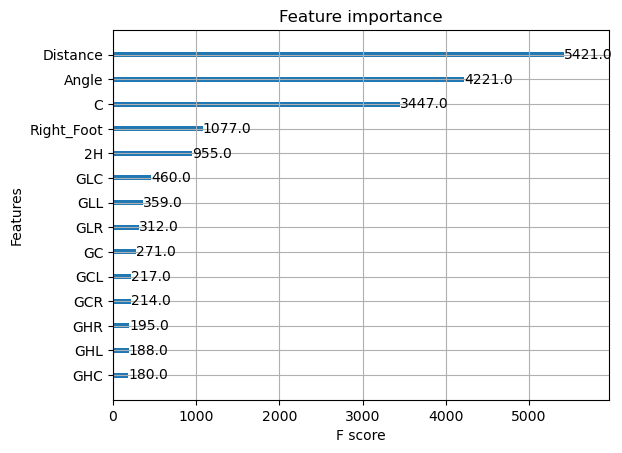

In [29]:
# Plot feature importance
xgb.plot_importance(best_xgb_model)
plt.show()

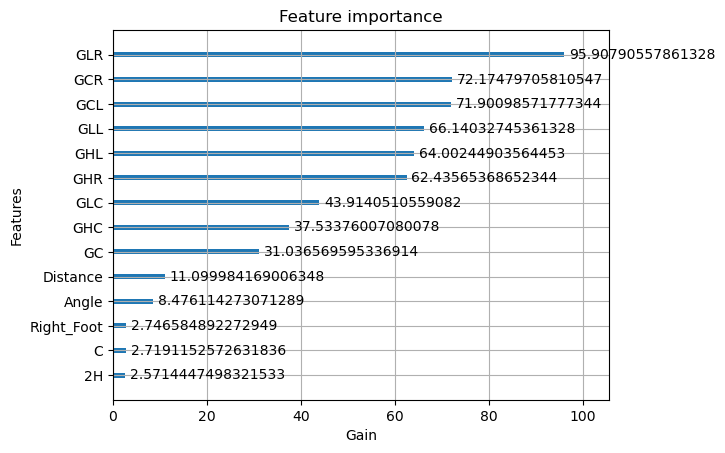

In [30]:
#We can also plot feature importance using two parameters:
# 1)gain: the 'gain' option displays the average gain of each feature when it is used in a tree

xgb.plot_importance(best_xgb_model, importance_type='gain', xlabel='Gain')
plt.show()

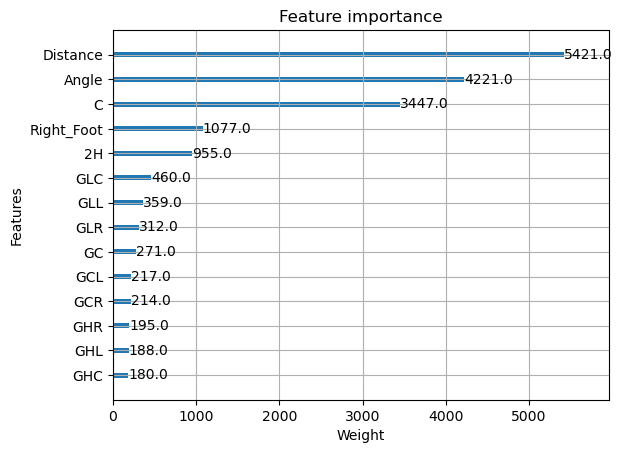

In [31]:
# 2)weight: The 'weight' option displays the number of times each feature appears in a tree

xgb.plot_importance(best_xgb_model, importance_type='weight', xlabel='Weight')
plt.show()


# Model 3: Random Forests

In [32]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
# using the same approach for train test split and CV as before
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Defining the outer loop for train-test split
cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Defining the inner loop for cross-validation on the training set
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [34]:
# Determine scale_pos_weight based on class imbalance
count_class_0, count_class_1 = y_train.value_counts()
# Class imbalance in training data
weight_0 = count_class_0 / (count_class_0 + count_class_1)
weight_1 = count_class_1 / (count_class_0 + count_class_1)
print ('Weight of Shots Class in Training: ',weight_0)
print ('Weight of Goal Class in Training: ', weight_1)

Weight of Shots Class in Training:  0.896330923947203
Weight of Goal Class in Training:  0.10366907605279699


In [35]:
# Define the hyperparameters to tune
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 5, 7,9, 12, 15],
              'min_samples_split': [2, 5, 10],
              'class_weight': ['balanced', {0: weight_0, 1: weight_1}]}

In [36]:
# Define the random forest model
rf_model = RandomForestClassifier()


In [37]:
start_time = time.time()
# Perform nested cross-validation with grid search
grid_rf = GridSearchCV(rf_model, param_grid=param_grid, cv=cv_inner, scoring='f1', n_jobs=-1)
scores_rf = cross_val_score(grid, X_train, y_train, cv=cv_outer, scoring='f1', n_jobs=-1)

In [38]:
# Fit the best model on the entire training set
grid_rf.fit(X_train, y_train)
best_rf_model = grid_rf.best_estimator_

end_time = time.time()

rf_training_time = end_time - start_time

In [39]:
# Print the best parameters
print("Best parameters: ", grid_rf.best_params_)
print ("Model Training Time: {:.3f} seconds".format(rf_training_time))

Best parameters:  {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 200}
Model Training Time: 787.800 seconds


## Model Performance on Training

In [40]:
# Brier score on training data
rf_brs_train = brier_score_loss(y_train, best_rf_model.predict_proba(X_train)[:, 1])
# Classfication report for training data and brier score
print (classification_report(y_train, best_rf_model.predict(X_train)),rf_brs_train, end= " is the brier score on training data" )

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22817
           1       0.60      0.96      0.74      2639

    accuracy                           0.93     25456
   macro avg       0.80      0.94      0.85     25456
weighted avg       0.95      0.93      0.94     25456
 0.05220923633111644 is the brier score on training data

## Model Performance in Testing

In [41]:
# Evaluate the performance of the best model on the testing set
y_pred_rf = best_rf_model.predict(X_test)


In [42]:
# Classfication report and brier score  for testing data
rf_brs_test = brier_score_loss(y_test, best_rf_model.predict_proba(X_test)[:, 1])
print (classification_report(y_test, y_pred_rf), rf_brs_test, end= " is the brier score on testing data")

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7672
           1       0.46      0.75      0.57       814

    accuracy                           0.89      8486
   macro avg       0.71      0.83      0.75      8486
weighted avg       0.92      0.89      0.90      8486
 0.07434531314574742 is the brier score on testing data

## Plotting Feature Importance

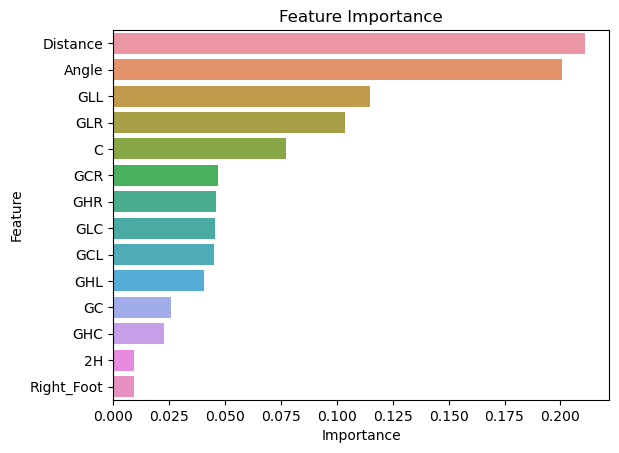

In [43]:
# Extract feature importances
importances = best_rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X_train.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Create barplot using seaborn
sns.barplot(x=importances[indices], y=names)

# Add x and y axis labels
plt.xlabel("Importance")
plt.ylabel("Feature")

# Show plot
plt.show()

# Summary  of model's Results

In [51]:
# Precision scores for the four models on training data
prec_lr_train = precision_score(y_train, best_lr_model.predict(X_train))

prec_xgb_train = precision_score(y_train, best_xgb_model.predict(X_train))

prec_rf_train = precision_score(y_train, best_rf_model.predict(X_train))

#prec_svm_train = precision_score(y_train, best_svm_model.predict(X_train))

prec_train = [prec_lr_train, prec_xgb_train, prec_rf_train]

# Precision scores for the four models on testing data
prec_lr_test = precision_score(y_test, y_pred)

prec_xgb_test = precision_score(y_test, y_pred_xgb)

prec_rf_test = precision_score(y_test, y_pred_rf)

#prec_svm_test = precision_score(y_test, y_pred_svm)

prec_test = [prec_lr_test, prec_xgb_test, prec_rf_test]

# Recall scores for the four models on training data
rec_lr_train = recall_score(y_train, best_lr_model.predict(X_train))

rec_xgb_train = recall_score(y_train, best_xgb_model.predict(X_train))

rec_rf_train = recall_score(y_train, best_rf_model.predict(X_train))

#rec_svm_train = recall_score(y_train, best_svm_model.predict(X_train))

rec_train = [rec_lr_train, rec_xgb_train, rec_rf_train]


# Calculting Recall for the four models on test data
rec_lr_test = recall_score(y_test, y_pred)

rec_xgb_test = recall_score(y_test, y_pred_xgb)

rec_rf_test = recall_score(y_test, y_pred_rf)

#rec_svm_test = recall_score(y_test, y_pred_svm)

rec_test = [rec_lr_test, rec_xgb_test, rec_rf_test]

# Accuracy scores for the four models on training data
acc_lr_train = accuracy_score(y_train, best_lr_model.predict(X_train))

acc_xgb_train = accuracy_score(y_train, best_xgb_model.predict(X_train))

acc_rf_train = accuracy_score(y_train, best_rf_model.predict(X_train))

#acc_svm_train = accuracy_score(y_train, best_svm_model.predict(X_train))

acc_train = [acc_lr_train, acc_xgb_train, acc_rf_train]

# Calculating Accuracy for the four models on test data
acc_lr_test = accuracy_score(y_test, y_pred)

acc_xgb_test = accuracy_score(y_test, y_pred_xgb)

acc_rf_test = accuracy_score(y_test, y_pred_rf)

#acc_svm_test = accuracy_score(y_test, y_pred_svm)

acc_test = [acc_lr_test, acc_xgb_test, acc_rf_test]
# Brier score for four models on training data
BRS_train = [LR_BRS_train, xgb_BRS_train, rf_brs_train]
# Brier score for four models on test data
BRS_test = [LR_BRS_test, xgb_BRS_test, rf_brs_test]


# Model training time
train_time =[lr_training_time/60, xgb_training_time/60, rf_training_time/60]

In [53]:
# Creating of dataframe of summary results
summary_df = pd.DataFrame({'Model Name':['Logistic Regression','XG Boost','Random Forests'],
                          'Training Accuracy': acc_train, 'Training Precision': prec_train,'Training Recall':rec_train,'Training Brier': BRS_train,
                          'Testing Accuracy': acc_test, 'Testing Precision': prec_test,'Testing Recall':rec_test, 'Testing Brier': BRS_test,
                          'Training Time (mins)': train_time})

summary_df.set_index('Model Name', inplace=True)
# Displaying summary of results
summary_df.style.format(precision =3).highlight_max(color='cyan').set_properties(**{'font-weight': 'bold',
            'border': '2.0px solid grey','color': 'purple'}).highlight_min(color='yellow')


,Training Accuracy,Training Precision,Training Recall,Training Brier,Testing Accuracy,Testing Precision,Testing Recall,Testing Brier,Training Time (mins)
Model Name,,,,,,,,,
Logistic Regression,0.827,0.370,0.953,0.107,0.821,0.344,0.955,0.110,0.487
XG Boost,0.904,0.520,0.995,0.064,0.867,0.404,0.822,0.092,20.220
Random Forests,0.929,0.600,0.958,0.052,0.890,0.457,0.752,0.074,13.130
